<a href="https://colab.research.google.com/github/josephasal/cosmo_inference/blob/main/MCMC_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#loading in the data from google drive, cleaning and assigning variables
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/LOWZ+ESSENCE+SNLS.csv'
supernova_df = pd.read_csv(filepath)

supernova_df.head()

#defining variables
redshift = supernova_df['Z']
distance_mod = supernova_df['MU']
err_distance_mod = supernova_df['MUERR']

supernova_df.head()

,CID,Z,c,cerr,x1,x1err,x0,x0err,mb,mberr,MU,MUERR,covx0x1,covx0c,covx1c
0,90O,0.0306,-0.0615,0.0324,0.3063,0.3943,0.005963,0.000209,16.210047,0.038083,35.547001,0.106,0.000010,-0.000005,-0.003592
1,93B,0.0707,0.0594,0.0376,-0.6927,0.3300,0.000736,0.000035,18.469965,0.051633,37.396999,0.120,0.000001,-0.000001,-0.001280
2,92P,0.0263,-0.0777,0.0287,0.1607,0.4422,0.006898,0.000143,16.053383,0.022515,35.415001,0.097,-0.000016,-0.000003,-0.001496
3,93H,0.0248,0.1963,0.0412,-2.8668,0.2425,0.003563,0.000169,16.743837,0.051566,35.095001,0.139,0.000007,-0.000006,-0.002212
4,93O,0.0519,-0.0666,0.0271,-0.9641,0.2376,0.001618,0.000035,17.626810,0.023160,36.840000,0.086,-0.000004,-0.000001,0.000531


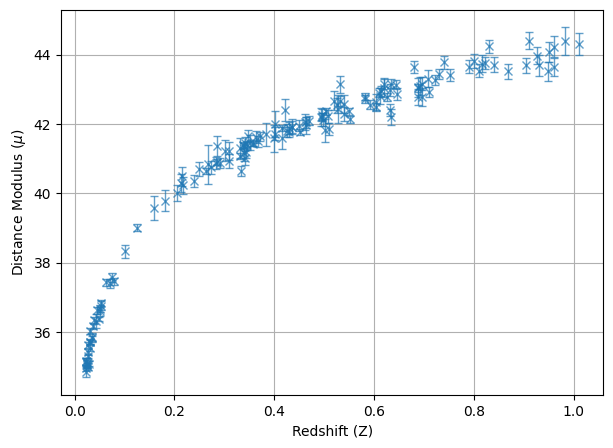

In [ ]:
#quick plots of redshift against distance mod and error
plt.figure(figsize = (7,5))
plt.errorbar(redshift,distance_mod,err_distance_mod, linestyle = 'None', marker = 'x', elinewidth=1, capsize=3, capthick=1, alpha=0.7)
plt.xlabel('Redshift (Z)')
plt.ylabel('Distance Modulus $(\mu)$')
plt.grid()
plt.show()

In [ ]:
#Dimensionless distance modulus function implementation

#Distance modulus function
def calculate_distance_modulus(z, omega_m,h):
  """
  Calculates dimensionless theoretical distance modulus using

  inputs:
   - z: Redshift
   - omega_m: density matter parameter
   - h: dimensionless hubble constance H0 = 100h km/s/Mpc

   outputs: theoretical distance modulus
  """
  c = 299792.458   # speed of light in km/s
  H0 = 100 * h     # Hubble constant in km/s/Mpc

  #Luminosity distance based on Penn 1999 analytic solution

  #Fitting function
  def eta(a,omega_m):
    """
    Fits eta
    inputs:
      a - a number
      omega_m - matter density

    outputs: eta as a function of a and omega_m
    """
    s = ((1-omega_m)/omega_m)**(1/3)
    eta = 2*np.sqrt(s**3 +1) * ((1/(a**4)) - 0.1540*(s/(a**3)) + 0.4304 *((s**2)/(a**2)) + 0.19097*((s**3)/a) + 0.066941*(s**4))**(-1/8)

    return eta

  #Calculate eta for 1 and 1/z+1
  a = 1/(z+1)
  eta_1 = eta(1,omega_m)
  eta_z = np.array([eta(ai, omega_m) for ai in a])

  #Dimensionless luminosity distance calculation
  d_L_star = (c/H0) * (1+z) * (eta_1 - eta_z)



  #Now to calculate distance modulus mu
  theoretical_mu = 25 - 5*np.log10(h) + 5*np.log10(d_L_star)
  return theoretical_mu

In [ ]:
#MCMC basic implementation

#Liklihood function, standard gaussian function

def log_likelihood(mu_obs, mu_model, sigma_mu):

  """
  Computes thes logged likelihood for the sample and observed distance modulus

  inputs:
    - mu_obs: observed mu (mu from the data)
    - mu_model: theoretical mu from the model
    - sigma_mu: standard deviation of the observed mu (uncertainty)

  outputs:
    - log likelihood

  """
  return -0.5 * np.sum((mu_obs - mu_model)**2/sigma_mu**2)


#Metropolis Hastings algorithm

def metropolis_hastings(likelihood, z, mu_obs, sigma_mu, n_steps, initial_params, step_size):
  """
  Perform Metropolis Hastings MCMC to sample from the posterior

  inputs:
    - likelihood: function to compute the likelihood
    - z: redshift
    - mu_obs: observed mu
    - sigma_mu: standard deviation of the observed mu
    - n_steps: Number of steps for MCMC
    -intial_params: initial guesses for [omega_m, h]
    - step size: proposal step size for [omega_m, h]

  outputs:
  Array of accepted parameter samples, reflecting the posterior

  """
  params = np.array(initial_params)
  samples = []

  for step in range (n_steps):
    #guess for new parameters
    proposed_params = params + np.random.normal(0, step_size, size = 2)
    omega_m_proposed, h_proposed = proposed_params

    # Priors on Omega_m and h:
    if not (0.1 < omega_m_proposed < 0.5 and 0.4 < h_proposed < 0.9):
      samples.append(params)
      continue

    #Distance modulus with proposed parameters
    proposed_mu_model = calculate_distance_modulus(z, proposed_params[0], proposed_params[1])

    #Log likelihood of proposed parameters
    proposed_log_likelihood = log_likelihood(mu_obs, proposed_mu_model, sigma_mu)

    #Log likelihood of current parameters, initially inputted from the function
    current_mu_model = calculate_distance_modulus(z, params[0], params[1])
    current_likelihood = log_likelihood(mu_obs, current_mu_model, sigma_mu)

    #Calculate the acceptance probability

    delta_log_likelihood = proposed_log_likelihood - current_likelihood
    #Implementing explicit overflow protection

    #If the difference in likelihoods is at max python limit, then accept the new proposal with probaiblity 1. Means new parameters are leng
    if delta_log_likelihood > 700:
      acceptance_probability = 1.0

    #If difference in likelihood is at min python limit, then dont accept the new proposal at all. Means new parameters are clapped
    elif delta_log_likelihood < -700:
      acceptance_probability = 0.0

    #If difference something else then we accept with probability below and randomly sample. Lets us explore parameter space
    else:
      acceptance_probability = min(1, np.exp(delta_log_likelihood))


    u = np.random.uniform(0,1)

    #Accept proposed move
    if u < acceptance_probability:
      params = proposed_params

    samples.append(params)

  return np.array(samples)




In [ ]:
#Testing the MCMC algorithm
n_steps = 10000
initial_params = [0.25, 0.65]
step_size = [0.001, 0.001]

samples = metropolis_hastings(log_likelihood, redshift, distance_mod, err_distance_mod, n_steps, initial_params, step_size)


In [ ]:
#Calculating the acceptance rate

acceptance_rate = np.mean([np.all(samples[i] != samples[i-1]) for i in range(1, len(samples))])
print(f"Acceptance Rate: {acceptance_rate:.3f}")


Acceptance Rate: 0.834


[[0.25       0.65      ]
 [0.25097012 0.65060767]
 [0.25189625 0.6514543 ]
 ...
 [0.2782336  0.83840189]
 [0.2782336  0.83840189]
 [0.27897077 0.83733355]]


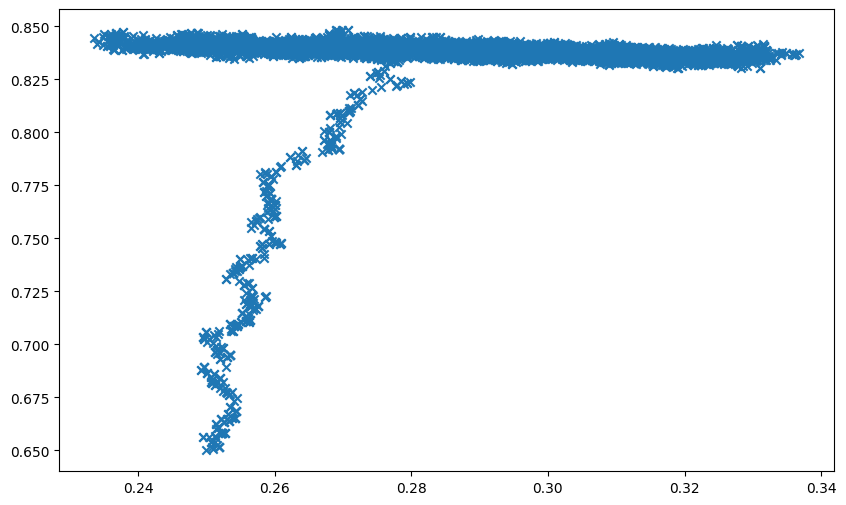

In [ ]:
#Inspecting the values

print(samples)
samples.shape
plt.figure(figsize = (10,6))
plt.scatter(samples[:,0],samples[:,1], marker = 'x')
plt.show()

#idk some kind of visualisation of the values, lets me see it

In [ ]:
#Corner plots of this test
!pip install corner

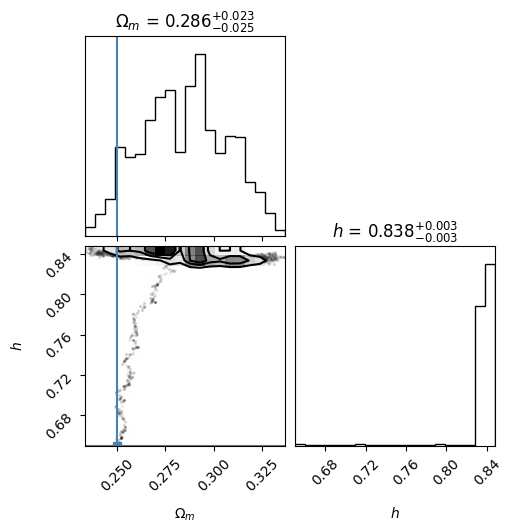

In [ ]:
import corner

fig = corner.corner(samples, labels=["$\Omega_m$", "$h$"],
                    truths=initial_params,
                    show_titles=True,
                    title_fmt=".3f")

plt.show()